In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import seaborn as sns
import warnings
import datetime as dt
from datetime import timedelta
warnings.filterwarnings('ignore')

sns.set()

In [2]:
%store -r cleandata
%store -r sarima_result
%store -r price_trend

In [3]:
cleandata.head()

,resale_date,resale_year,resale_month,lease_commence_year,remaining_lease,town,block,street_name,storey_range,floor_area_sqm,flat_model,flat_type,resale_price
0,2017-01-01,2017,1,1979,61,ANG MO KIO,406,ANG MO KIO AVE 10,10 TO 12,44.0,IMPROVED,2 ROOM,232000.0
1,2017-01-01,2017,1,1978,60,ANG MO KIO,108,ANG MO KIO AVE 4,01 TO 03,67.0,NEW GENERATION,3 ROOM,250000.0
2,2017-01-01,2017,1,1980,62,ANG MO KIO,602,ANG MO KIO AVE 5,01 TO 03,67.0,NEW GENERATION,3 ROOM,262000.0
3,2017-01-01,2017,1,1980,62,ANG MO KIO,465,ANG MO KIO AVE 10,04 TO 06,68.0,NEW GENERATION,3 ROOM,265000.0
4,2017-01-01,2017,1,1980,62,ANG MO KIO,601,ANG MO KIO AVE 5,01 TO 03,67.0,NEW GENERATION,3 ROOM,265000.0


In [4]:
%store -r months_order

## 4.1 Numerical Predictors

In [5]:
# At this point no need to change the numerical features

## 4.2 Categorical Predictors

### Ordinal Encoding

In [6]:
# As I have mentioned in EDA part, we discovered that flat_type and storey_range are ordinal variables
# that have nearly linear relationship with average resale_price.
# Therefore, we can change it into numeric
# so as to make the future models simpler
# because too many categories leads to "the curse of dimensionality"

#### Flat Type

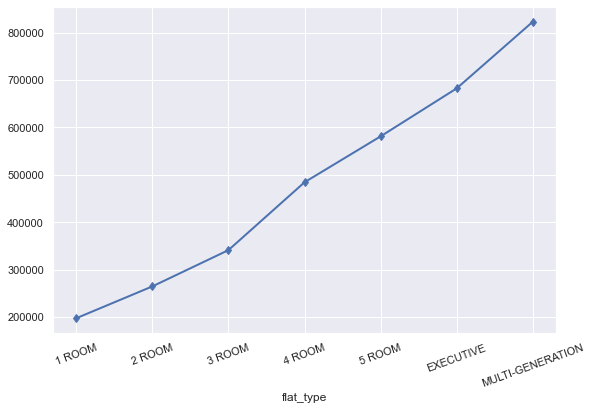

In [7]:
ft = cleandata.groupby('flat_type')['resale_price'].mean()

plt.figure(figsize=[9,6])
ft.plot(marker = 'd', linewidth = 2)
plt.xticks(rotation = 20)
plt.savefig('flat type average.png');

In [8]:
from sklearn.preprocessing import OrdinalEncoder

ftype_order = np.sort(cleandata['flat_type'].unique())
ft_encoder = OrdinalEncoder(categories=[ftype_order])

cleandata['flat_type'] = ft_encoder.fit_transform(cleandata['flat_type'].values.reshape(-1, 1))
cleandata['flat_type'] = cleandata['flat_type'].astype(int)
np.sort(cleandata['flat_type'].unique())

array([0, 1, 2, 3, 4, 5, 6])

#### Storey Range

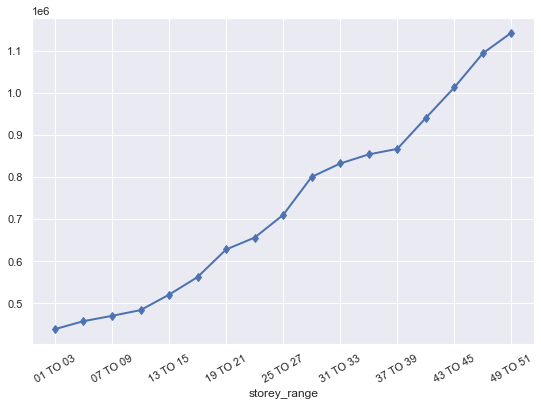

In [9]:
st = cleandata.groupby('storey_range')['resale_price'].mean()

plt.figure(figsize=[9,6])
st.plot(marker = 'd', linewidth = 2)
plt.xticks(rotation = 30)
plt.savefig('storey range average.png');

In [10]:
storey_order = np.sort(cleandata['storey_range'].unique())
st_encoder = OrdinalEncoder(categories=[storey_order])

cleandata['storey_range'] = st_encoder.fit_transform(cleandata['storey_range'].values.reshape(-1, 1))
cleandata['storey_range'] = cleandata['storey_range'].astype(int)
np.sort(cleandata['storey_range'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

## 4.3 Temporal Predictors

In [11]:
time = cleandata.iloc[:,:5]
others = cleandata.iloc[:,5:]

In [12]:
time.head()

,resale_date,resale_year,resale_month,lease_commence_year,remaining_lease
0,2017-01-01,2017,1,1979,61
1,2017-01-01,2017,1,1978,60
2,2017-01-01,2017,1,1980,62
3,2017-01-01,2017,1,1980,62
4,2017-01-01,2017,1,1980,62


### month

In [13]:
cleandata['resale_month'] = cleandata['resale_date'].dt.strftime('%b')
cleandata['resale_month'] = pd.Categorical(cleandata['resale_month'], categories= months_order, ordered = True)

### quarter

In [14]:
cleandata['resale_quarter'] = cleandata['resale_date'].dt.quarter.astype(str)
cleandata['resale_quarter'] = 'Q'+cleandata['resale_quarter']

In [15]:
price_predict = sarima_result.predict().apply(np.exp)
price_predict1 = price_predict.reset_index()
price_forecast = sarima_result.forecast(steps = len(price_trend) - len(sarima_result.predict())).apply(np.exp) # series
price_forecast1 = price_forecast.reset_index() 
price_forecast1 = price_forecast1.rename(columns = {'index': 'resale_date'}) # make dataframe

In [16]:
#fix the extreme values with interpolation

price_predict1.iloc[0,1] = np.nan
price_predict1.iloc[12,1] = np.nan
price_predict1['predicted_mean'] = price_predict1['predicted_mean'].interpolate(method = 'linear')

In [17]:
prediction = pd.concat([price_predict1, price_forecast1], axis = 0)

In [18]:
prediction['lag1'] = prediction['predicted_mean'].shift(1)
prediction['lag2'] = prediction['predicted_mean'].shift(2)
prediction['lag3'] = prediction['predicted_mean'].shift(3)
prediction['lag4'] = prediction['predicted_mean'].shift(4)
prediction

,resale_date,predicted_mean,lag1,lag2,lag3,lag4
0,2017-01-01,NaN,NaN,NaN,NaN,NaN
1,2017-02-01,427478.107799,NaN,NaN,NaN,NaN
2,2017-03-01,447295.950889,427478.107799,NaN,NaN,NaN
3,2017-04-01,444852.246916,447295.950889,427478.107799,NaN,NaN
4,2017-05-01,438553.119984,444852.246916,447295.950889,427478.107799,NaN
...,...,...,...,...,...,...
7,2023-04-01,565935.890491,562510.685839,560573.505124,552042.786047,558060.020263
8,2023-05-01,567773.138845,565935.890491,562510.685839,560573.505124,552042.786047
9,2023-06-01,564935.989380,567773.138845,565935.890491,562510.685839,560573.505124
10,2023-07-01,567751.437004,564935.989380,567773.138845,565935.890491,562510.685839


In [19]:
cleandata1 = pd.merge(cleandata, prediction, on = 'resale_date', how = 'outer')
cleandata1 = pd.merge(cleandata1, price_trend, on = 'resale_date', how = 'outer')

## 4.4 Feature Selection

In [20]:
newdata = cleandata1.dropna()
newdata.head()

,resale_date,resale_year,resale_month,lease_commence_year,remaining_lease,town,block,street_name,storey_range,floor_area_sqm,flat_model,flat_type,resale_price,resale_quarter,predicted_mean,lag1,lag2,lag3,lag4,trend
7925,2017-06-01,2017,Jun,1986,68,ANG MO KIO,174,ANG MO KIO AVE 4,2,45.0,IMPROVED,1,233000.0,Q2,443652.372539,438553.119984,444852.246916,447295.950889,427478.107799,444038.092571
7926,2017-06-01,2017,Jun,1978,60,ANG MO KIO,314,ANG MO KIO AVE 3,2,44.0,IMPROVED,1,250000.0,Q2,443652.372539,438553.119984,444852.246916,447295.950889,427478.107799,444038.092571
7927,2017-06-01,2017,Jun,1976,58,ANG MO KIO,218,ANG MO KIO AVE 1,2,67.0,NEW GENERATION,2,235000.0,Q2,443652.372539,438553.119984,444852.246916,447295.950889,427478.107799,444038.092571
7928,2017-06-01,2017,Jun,1980,62,ANG MO KIO,465,ANG MO KIO AVE 10,2,68.0,NEW GENERATION,2,260000.0,Q2,443652.372539,438553.119984,444852.246916,447295.950889,427478.107799,444038.092571
7929,2017-06-01,2017,Jun,1981,63,ANG MO KIO,151,ANG MO KIO AVE 5,0,68.0,NEW GENERATION,2,260000.0,Q2,443652.372539,438553.119984,444852.246916,447295.950889,427478.107799,444038.092571


In [21]:
# check whether there is any inappropriate values

num = newdata.select_dtypes(include = 'number') #numerical
cat = newdata.select_dtypes(exclude = 'number') #categorical/qualitative

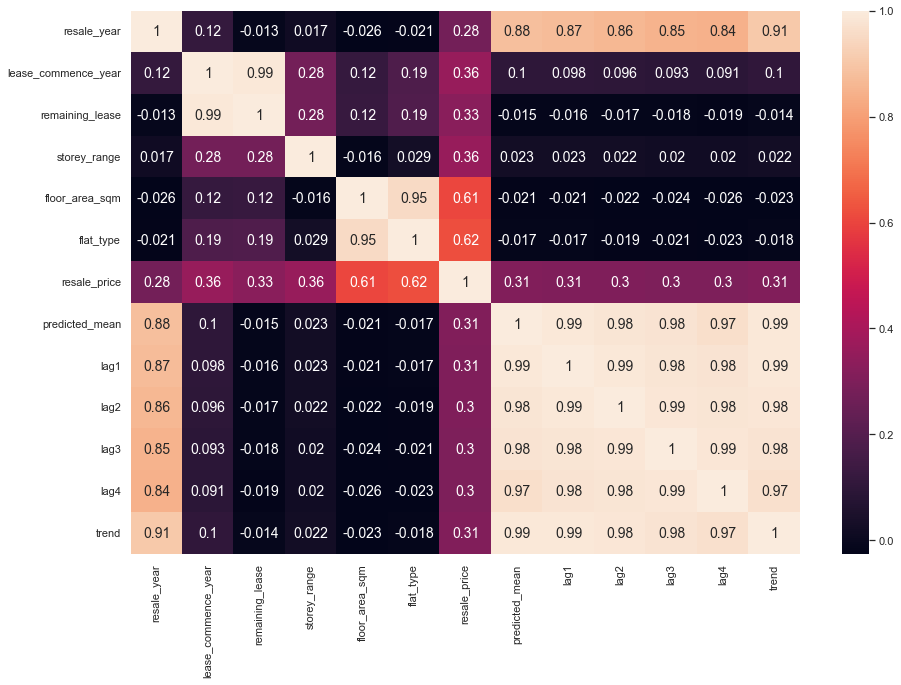

In [22]:
plt.figure(figsize= [15, 10])
sns.heatmap(num.corr(), annot = True, annot_kws={'size': 14});

# from the heatmap below, we can tell which features are multicollinear
# since we already know that remaining lease is a function of lease_commence_year
# I think it is safe to drop one of those two features
# Meanwhile, we would like to keep the rest at this point and just see how the model behaves later on

plt.figure(figsize= [10, 7])
sns.heatmap(num.iloc[:,:7].corr(method = 'spearman'), annot = True, annot_kws={'size': 14})
plt.savefig('corr num.png');

plt.figure(figsize= [10, 7])
sns.heatmap(num.iloc[:,6:].corr(method = 'pearson'), annot = True, annot_kws={'size': 14})
plt.savefig('corr TS.png');

In [25]:
for i, column in enumerate(cat.columns):
    print(f'{column}'.title(), ': contains', cat[column].nunique(), 'values')

    # we would also just drop block and street_name because 
    # they have extremely large values (2672 values and 565 values, respectively)

Resale_Date : contains 75 values
Resale_Month : contains 12 values
Town : contains 26 values
Block : contains 2671 values
Street_Name : contains 565 values
Flat_Model : contains 21 values
Resale_Quarter : contains 4 values


In [26]:
feature_candidates = newdata.drop(['remaining_lease', 'block', 'street_name'], axis = 1)
feature_candidates = feature_candidates.rename({'predicted_mean':'sarima_forecast'}, axis = 1)

# rename predicted_mean (which came from SARIMA forecasting) to sarima_forecast to avoid confusion

In [27]:
feature_candidates.head()

,resale_date,resale_year,resale_month,lease_commence_year,town,storey_range,floor_area_sqm,flat_model,flat_type,resale_price,resale_quarter,sarima_forecast,lag1,lag2,lag3,lag4,trend
7925,2017-06-01,2017,Jun,1986,ANG MO KIO,2,45.0,IMPROVED,1,233000.0,Q2,443652.372539,438553.119984,444852.246916,447295.950889,427478.107799,444038.092571
7926,2017-06-01,2017,Jun,1978,ANG MO KIO,2,44.0,IMPROVED,1,250000.0,Q2,443652.372539,438553.119984,444852.246916,447295.950889,427478.107799,444038.092571
7927,2017-06-01,2017,Jun,1976,ANG MO KIO,2,67.0,NEW GENERATION,2,235000.0,Q2,443652.372539,438553.119984,444852.246916,447295.950889,427478.107799,444038.092571
7928,2017-06-01,2017,Jun,1980,ANG MO KIO,2,68.0,NEW GENERATION,2,260000.0,Q2,443652.372539,438553.119984,444852.246916,447295.950889,427478.107799,444038.092571
7929,2017-06-01,2017,Jun,1981,ANG MO KIO,0,68.0,NEW GENERATION,2,260000.0,Q2,443652.372539,438553.119984,444852.246916,447295.950889,427478.107799,444038.092571


In [28]:
feature_candidates_rearranged = feature_candidates[['resale_price', 'resale_date','resale_year', 'resale_month', 'resale_quarter', 'lease_commence_year', 'storey_range', 'town', 'flat_model', 'floor_area_sqm', 'sarima_forecast','lag1', 'lag2', 'lag3', 'lag4', 'trend']]
#rearrange features

In [29]:
feature_baseline = feature_candidates_rearranged.iloc[:,:10]
feature_baseline.head()

,resale_price,resale_date,resale_year,resale_month,resale_quarter,lease_commence_year,storey_range,town,flat_model,floor_area_sqm
7925,233000.0,2017-06-01,2017,Jun,Q2,1986,2,ANG MO KIO,IMPROVED,45.0
7926,250000.0,2017-06-01,2017,Jun,Q2,1978,2,ANG MO KIO,IMPROVED,44.0
7927,235000.0,2017-06-01,2017,Jun,Q2,1976,2,ANG MO KIO,NEW GENERATION,67.0
7928,260000.0,2017-06-01,2017,Jun,Q2,1980,2,ANG MO KIO,NEW GENERATION,68.0
7929,260000.0,2017-06-01,2017,Jun,Q2,1981,0,ANG MO KIO,NEW GENERATION,68.0


In [30]:
feature_sarima = feature_candidates_rearranged.copy()

In [31]:
%store feature_baseline
%store feature_sarima

Stored 'feature_baseline' (DataFrame)
Stored 'feature_sarima' (DataFrame)
